In [1]:
!pip install yfinance pandas numpy scikit-learn matplotlib


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


In [7]:
# User inputs
symbol = "AAPL"  # Change to any stock symbol
start_date = "2020-01-01"  # Longer date range ensures enough data
end_date = "2024-01-01"

# Download stock data
data = yf.download(symbol, start=start_date, end=end_date)

print(f"Downloaded {len(data)} rows for {symbol}")
data.head()


/tmp/ipython-input-914824369.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Downloaded 1006 rows for AAPL


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.538498,72.598876,71.292289,71.545875,135480400
2020-01-03,71.833290,72.594055,71.608685,71.765667,146322800
2020-01-06,72.405670,72.444313,70.703005,70.954181,118387200
2020-01-07,72.065155,72.671348,71.845377,72.415345,108872000
2020-01-08,73.224403,73.526295,71.768079,71.768079,132079200


In [8]:
# RSI function
def compute_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# MACD function
def compute_macd(data):
    short_ema = data['Close'].ewm(span=12, adjust=False).mean()
    long_ema = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
    return data

# Bollinger Bands function
def compute_bollinger_bands(data, window=20):
    middle_band = data['Close'].rolling(window=window).mean()
    std_dev = data['Close'].rolling(window=window).std()
    upper_band = middle_band + 2 * std_dev
    lower_band = middle_band - 2 * std_dev
    data['BB_Middle'] = middle_band
    data['BB_Upper'] = upper_band
    data['BB_Lower'] = lower_band
    return data

# Add features
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
data['RSI'] = compute_rsi(data)
data = compute_macd(data)
data = compute_bollinger_bands(data)
data['Price_Change'] = data['Close'].pct_change()

# Drop rows with NaN values
data.dropna(inplace=True)
print(f"Number of rows after adding indicators: {len(data)}")

# Check if enough data is available
if len(data) < 30:
    raise ValueError("Not enough data to train the model. Try a longer date range.")

data.tail()


Number of rows after adding indicators: 987


Price,Close,High,Low,Open,Volume,MA10,MA20,RSI,MACD,Signal_Line,BB_Middle,BB_Upper,BB_Lower,Price_Change
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,,
Date,,,,,,,,,,,,,,
2023-12-22,191.974701,193.769503,191.349985,193.541423,37149600,194.103658,192.042608,59.246160,2.635695,3.238393,192.042608,197.815759,186.269456,-0.005547
2023-12-26,191.429306,192.262250,191.211152,191.984602,28919300,194.090767,192.204240,49.031952,2.306987,3.052111,192.204240,197.698282,186.710199,-0.002841
2023-12-27,191.528442,191.875510,189.485739,190.873995,48087700,193.936075,192.340586,52.291455,2.031070,2.847903,192.340586,197.609818,187.071354,0.000518
2023-12-28,191.954834,193.025769,191.548272,192.510130,34049900,193.501752,192.549318,47.920354,1.825764,2.643475,192.549318,197.369519,187.729117,0.002226
2023-12-29,190.913651,192.767946,190.120364,192.272144,42672100,192.948433,192.677234,40.185149,1.561047,2.426990,192.677234,197.152234,188.202234,-0.005424


In [9]:
features = ['MA10', 'MA20', 'RSI', 'MACD', 'Signal_Line',
            'BB_Middle', 'BB_Upper', 'BB_Lower', 'Price_Change', 'Volume']
X = data[features]
y = data['Close']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RandomForest model
model = RandomForestRegressor(n_estimators=150, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
preds = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, preds):.2f}")
print(f"R² Score: {r2_score(y_test, preds):.2f}")


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MAE: 1.47
R² Score: 1.00


In [13]:
# Select last row as a NumPy array (2D) for prediction
last_row = data[features].iloc[[-1]].values  # double brackets keep it 2D

# Predict next-day price and extract scalar
next_day_price = float(model.predict(last_row))  # float() ensures it's a scalar

# Last closing price
last_close = float(data['Close'].iloc[-1])

# Determine trend
if next_day_price > last_close:
    trend = "Uptrend 📈"
elif next_day_price < last_close:
    trend = "Downtrend 📉"
else:
    trend = "Stable ➡️"

# Determine RSI status
rsi_value = float(data['RSI'].iloc[-1])
if rsi_value > 70:
    rsi_status = "Overbought ⚠️"
elif rsi_value < 30:
    rsi_status = "Oversold 💰"
else:
    rsi_status = "Neutral ✅"

# Print results
print(f"Last Closing Price: ${last_close:.2f}")
print(f"Predicted Next-Day Price: ${next_day_price:.2f}")
print(f"Trend: {trend}")
print(f"RSI: {rsi_status}")


Last Closing Price: $190.91
Predicted Next-Day Price: $190.62
Trend: Downtrend 📉
RSI: Neutral ✅


/tmp/ipython-input-2999497483.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_day_price = float(model.predict(last_row))  # float() ensures it's a scalar
/tmp/ipython-input-2999497483.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_close = float(data['Close'].iloc[-1])


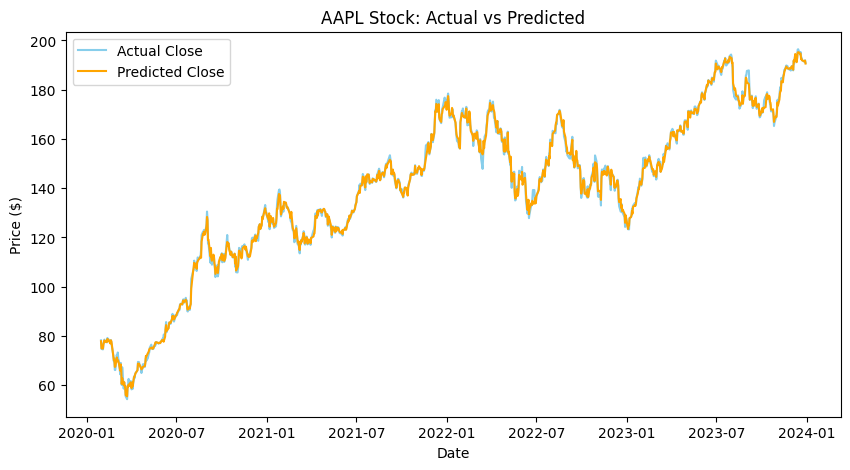

In [14]:
plt.figure(figsize=(10,5))
plt.plot(data.index, data['Close'], label='Actual Close', color='skyblue')
plt.plot(data.index, model.predict(X), label='Predicted Close', color='orange')
plt.title(f"{symbol} Stock: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()
